# Proyek Analisis Data: Bike Sharing Dataset
- **Nama:** Dian Azizah Lubis
- **Email:** dianazizah134@gmail.com | A295XBF125@devacademy.id
- **ID Dicoding:** A295XBF125

## Menentukan Pertanyaan Bisnis

- Bagaimana pola penyewaan yang berasal dari pengguna umum dibandingkan pengguna terdaftar?
- Apakah ada perbedaan penggunaan sepeda antara hari kerja dan akhir pekan, serta pada hari apa penggunaan tertinggi?
- Jam berapakah penggunaan sepeda tertinggi dalam sehari?

## Import Semua Packages/Library yang Digunakan

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from zipfile import ZipFile
import os

## Data Wrangling

### Gathering Data

In [109]:
# Specifying the zip file name
file_name = "/content/Bike-sharing-dataset.zip"

# Opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # Printing all the contents of the zip file
    zip.printdir()

    # Extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

File Name                                             Modified             Size
Readme.txt                                     2013-12-20 13:29:02         5607
day.csv                                        2013-12-20 12:10:44        57569
hour.csv                                       2013-12-20 12:10:44      1156736
Extracting all the files now...
Done!


In [110]:
hour_df = pd.read_csv('/content/hour.csv')
hour_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [111]:
day_df = pd.read_csv('/content/day.csv')
day_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


**Insight:**
- The hour data consists of 17 columns.
- The day data consists of 16 columns.

**Note:**
  I only use the hour.csv data because the content of the day.csv data is the same as hour.csv, except that it doesn't have the 'hr' column that refers to the hour of the bike rental.

### Assessing Data

In [112]:
hour_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [113]:
# Check for null data
print("Total null: ", hour_df.isna().sum())

Total null:  instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [114]:
# Check data for duplicates
print("Number of duplicates: ", hour_df.duplicated().sum())

Number of duplicates:  0


In [115]:
# Initiate dictionary to check column range
valid_ranges = {
    'season': range(1, 5),         # Seasons: 1 to 4 (1:springer, 2:summer, 3:fall, 4:winter)
    'yr': [0, 1],                  # Year: 0 (2011), 1 (2012)
    'mnth': range(1, 13),          # Months: 1 to 12
    'hr' : range(0,24),            # Hour: 24 hour
    'holiday': [0, 1],             # Holiday: 0 (No), 1 (Yes)
    'weekday': range(0, 7),        # Weekday: 0 (Sunday) to 6 (Saturday)
    'workingday': [0, 1],          # Working day: 0 (No), 1 (Yes)
    'weathersit': range(1, 5),     # Weather situations: 1 to 4
}

# List of datasets to check
datasets = {
    "hour_df": hour_df
}

# Loop through each dataset
for dataset_name, dataset in datasets.items():
    print(f"Checking dataset: {dataset_name}")

    # Initialize a report for invalid values
    invalid_values_report = {}

    # Loop through each variable and check for invalid values
    for column, valid_range in valid_ranges.items():
        if column in dataset.columns:
            # Check for invalid values
            invalid_rows = dataset[~dataset[column].isin(valid_range)]
            if not invalid_rows.empty:
                invalid_values_report[column] = invalid_rows

    # Display the results for the current dataset
    if not invalid_values_report:
        print("All variables have valid data.")
    else:
        print("The following variables have invalid data:")
        for column, invalid_rows in invalid_values_report.items():
            print(f"Variable '{column}' has invalid values in the following rows:")
            print(invalid_rows)

Checking dataset: hour_df
All variables have valid data.


In [116]:
# Check if there are negative values in the casual and registered columns (must be positive because of the number of the human)
renters = ['casual', 'registered']
invalid_renters = hour_df[
    (hour_df['casual'] < 0) | (hour_df['registered'] < 0)
]

if not invalid_renters.empty:
    print("There are invalid values in casual or registered (negative values):")
    print(invalid_renters)
else:
    print("The data is already valid.")

# Check if cnt is equal to casual + registered
def compare_data(df):
    compare = df[df['cnt'] != (df['casual'] + df['registered'])]

    if not compare.empty:
        print(f"\nMismatches found in {len(compare)} rows:")
        print(compare)
    else:
        print("\nAll match: cnt equals casual + registered for all rows.")

compare_data(hour_df)

The data is already valid.

All match: cnt equals casual + registered for all rows.


In [117]:
summary = hour_df.describe()
print(summary)

          instant        season            yr          mnth            hr  \
count  17379.0000  17379.000000  17379.000000  17379.000000  17379.000000   
mean    8690.0000      2.501640      0.502561      6.537775     11.546752   
std     5017.0295      1.106918      0.500008      3.438776      6.914405   
min        1.0000      1.000000      0.000000      1.000000      0.000000   
25%     4345.5000      2.000000      0.000000      4.000000      6.000000   
50%     8690.0000      3.000000      1.000000      7.000000     12.000000   
75%    13034.5000      3.000000      1.000000     10.000000     18.000000   
max    17379.0000      4.000000      1.000000     12.000000     23.000000   

            holiday       weekday    workingday    weathersit          temp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.028770      3.003683      0.682721      1.425283      0.496987   
std        0.167165      2.005771      0.465431      0.639357      0.

**Insight:**
- There are no **null or duplicate** values.
- **No invalid data** found on ordinal and nominal data.
- There are **no negative values in casual, registered, and cnt** columns.
- The number of tenants in the **cnt column matches** the number of tenants in the **casual+registered column**.
- The season column has a mean of 2.4 which shows the data records are concentrated between summer and fall.
- The wheahersit column shows an average of 1.3, this means that the weather conditions are clear, few clouds, partly cloudy, partly cloudy.
- The **dteday column** in data **has an object data type** that should be of datetime type.

### Cleaning Data

Cleaning data consists of 3 stages, i.e. define, code, and test.

1.   Define: Currently, the 'dteday' column is an object data type and needs to be converted to datetime.
2.   Code: Convert dteday data type to datetime.



In [118]:
hour_df['dteday'] = pd.to_datetime(hour_df['dteday'])

3. Test

In [119]:
print("Hour data types: ")
hour_df.info()

Hour data types: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  int64         
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  int64         
 9   weathersit  17379 non-null  int64         
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64         
 16  cnt 

**Insight:**
- The data type of the dteday column that contains the date of the bike rental has been changed from object to datetime.

## Exploratory Data Analysis (EDA)

### Explore hour data

In [120]:
hour_df.sample(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
8545,8546,2011-12-27,1,0,12,19,0,2,1,1,0.34,0.3333,0.87,0.1642,3,87,90
8982,8983,2012-01-15,1,1,1,3,0,0,0,2,0.16,0.1364,0.48,0.3881,1,24,25
4061,4062,2011-06-23,3,0,6,3,0,4,1,2,0.72,0.6970,0.74,0.1642,1,4,5
11288,11289,2012-04-20,2,1,4,13,0,5,1,1,0.62,0.6212,0.43,0.1940,105,276,381
1591,1592,2011-03-11,1,0,3,19,0,5,1,1,0.30,0.2727,0.56,0.3284,7,111,118


In [121]:
hour_df.describe(include="all")

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2012-01-02 04:08:34.552045568,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
min,1.0000,2011-01-01 00:00:00,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2011-07-04 00:00:00,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,2012-01-02 00:00:00,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,2012-07-02 00:00:00,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,2012-12-31 00:00:00,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000
std,5017.0295,NaN,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599


In [122]:
hour_df.instant.is_unique

True

**Distribution of casual to registered renters.**

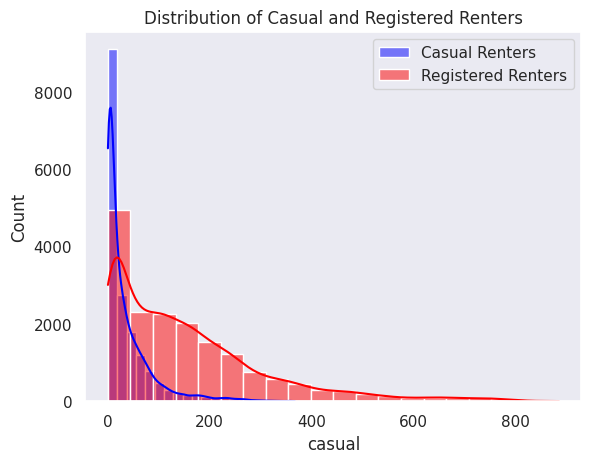

In [123]:
sns.histplot(hour_df['casual'], bins=20, kde=True, color='blue', label='Casual Renters')
sns.histplot(hour_df['registered'], bins=20, kde=True, color='red', label='Registered Renters')
plt.legend()
plt.title('Distribution of Casual and Registered Renters')
plt.show()

**Insight:**
For both casual and registered renters, the majority of rentals occur at low numbers, as can be seen from the high peak near the number of rentals of 0. Renters often rent bikes in small numbers, whether casual or registered.

1.   Casual Renters (Blue)
* The rental distribution of casual renters is highly centered around low values (below 100), with a sharper peak than that of registered renters. This suggests that casual renters are more likely to rent in small amounts and at higher frequencies.
* The data is right skewed distribution, as the data continues to decrease towards the left.


2.   Registered Renters (Red)
* The rental distribution of registered renters is flatter and wider than that of casual renters. This suggests that registered renters have a greater variation in the number of rentals, and more of them rent larger amounts.
* The data distribution is also skewed to the right, where the peak is lower than for casual renters but the decline is more stepwise compared to casual renters, which is in stark contrast.

In the KDE curve, it can be seen that the peak for casual tenants is very sharp at a low number, while the curve for registered tenants is more gentle, which again shows that registered renters have a more dispersed rental distribution.



**Identify outliers in casual and registered columns**

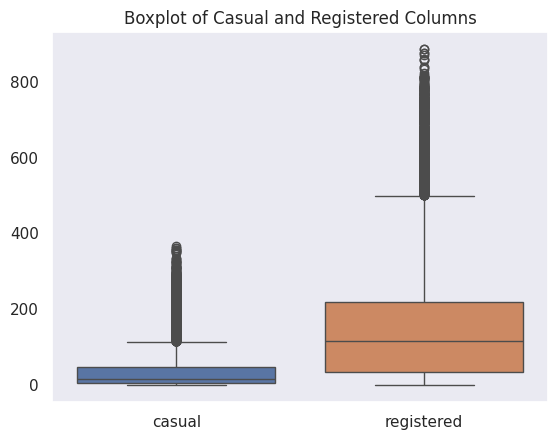

In [124]:
sns.boxplot(data=hour_df[['casual', 'registered']])
plt.title('Boxplot of Casual and Registered Columns')
plt.show()

**Insight:**

1.   Casual Renters (Blue)
- The small size of the box indicates limited data variation.
- Casual renters have a very small median and IQR, indicating that most rentals by casual users occur in relatively small numbers.
- The outlier is above the maximum limit, which indicates an unusual spike in high rental demand.
2.   Registered renters (Orange)
- Wider boxes indicate greater variation in the data.
- The median for registered renters is much higher and the IQR for registered renters is wider than for casual renters, indicating that the variation in the number of rentals among registered renters is greater.
- The outlier is above the maximum limit, which indicates an unusual spike in high rental demand.
- Outliers in registered renters are larger in number, indicating that there are some rentals that are very high compared to the average.

Overall, registered renters are more active and have a greater number and variety of rentals than casual renters.



**Check outliers using IQR**

In [125]:
# Initialize the 'is_outlier' column with False
hour_df['is_outlier'] = False

for column in ['casual', 'registered']:
    Q1 = hour_df[column].quantile(0.25)
    Q3 = hour_df[column].quantile(0.75)
    IQR = Q3 - Q1
    min_value = Q1 - (1.5 * IQR)
    max_value = Q3 + (1.5 * IQR)

    # Identify outliers
    outliers = hour_df[(hour_df[column] < min_value) | (hour_df[column] > max_value)]

    # Mark rows with outliers in the 'is_outlier' column
    hour_df.loc[outliers.index, 'is_outlier'] = True

    print(f"Outliers in {column}: {len(outliers)} rows")
    print(f"Outlier values for {column}:")
    print(outliers[[column]])

# Verify the 'is_outlier' column
hour_df[['casual', 'registered', 'is_outlier']].head()

# Remove outliers
df__hour_no_outliers = hour_df[hour_df['is_outlier'] == False]

Outliers in casual: 1192 rows
Outlier values for casual:
       casual
1633      144
1634      149
1635      124
1771      126
1772      174
...       ...
16817     122
16818     148
16819     164
16820     167
16821     139

[1192 rows x 1 columns]
Outliers in registered: 680 rows
Outlier values for registered:
       registered
2995          539
3019          532
3067          540
3187          521
3379          524
...           ...
17063         512
17077         665
17086         536
17087         546
17101         585

[680 rows x 1 columns]


**Visualize boxplot after removing outliers**

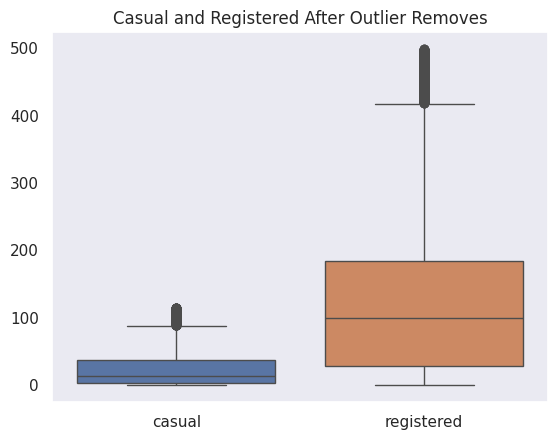

In [126]:
sns.boxplot(data=df__hour_no_outliers[['casual', 'registered']])
plt.title('Casual and Registered After Outlier Removes')
plt.show()

****

**Distribution of casual to registered renters after outlier removes**

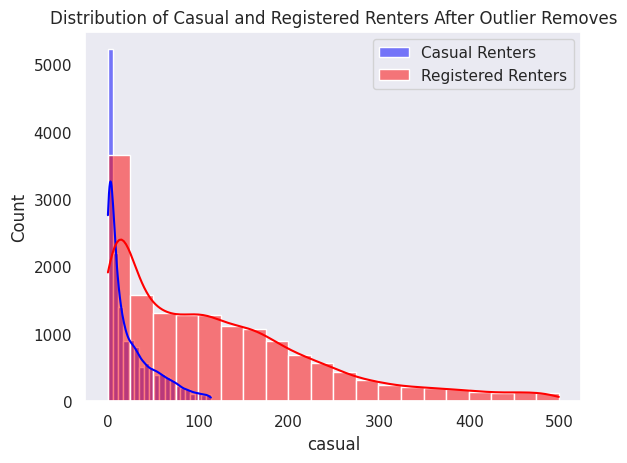

In [127]:
sns.histplot(df__hour_no_outliers['casual'], bins=20, kde=True, color='blue', label='Casual Renters')
sns.histplot(df__hour_no_outliers['registered'], bins=20, kde=True, color='red', label='Registered Renters')
plt.legend()
plt.title('Distribution of Casual and Registered Renters After Outlier Removes')
plt.show()

**Insight:**

1.   Distribution of Casual Renters (Blue Line and Bar)

*   The distribution for casual renters has a very sharp peak in the small number range, indicating that most rentals by casual renters are in very small numbers.
* The graph has a long tail to the right, indicating there are some larger rentals, although they are few in number.
* After the outliers are removed, the range of the distribution of casual renters is centered on rentals of about 0 to 100 bikes.

2.   Distribution of Registered Renters (Red Lines and Bars)
* Registered renters also show a small peak, but their distribution is more spread out than casual renters.
* The long tail to the right is more pronounced compared to casual renters, indicating that there are more large rentals among registered renters.
* The distribution of registered renters is more spread out to 500 bikes, indicating that they are more likely to rent a larger number of bikes than casual renters.




In [128]:
hour_df.head(1)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,is_outlier
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,False


## Visualization & Explanatory Analysis

### Pertanyaan 1: Bagaimana pola penyewaan yang berasal dari pengguna umum dibandingkan pengguna terdaftar?

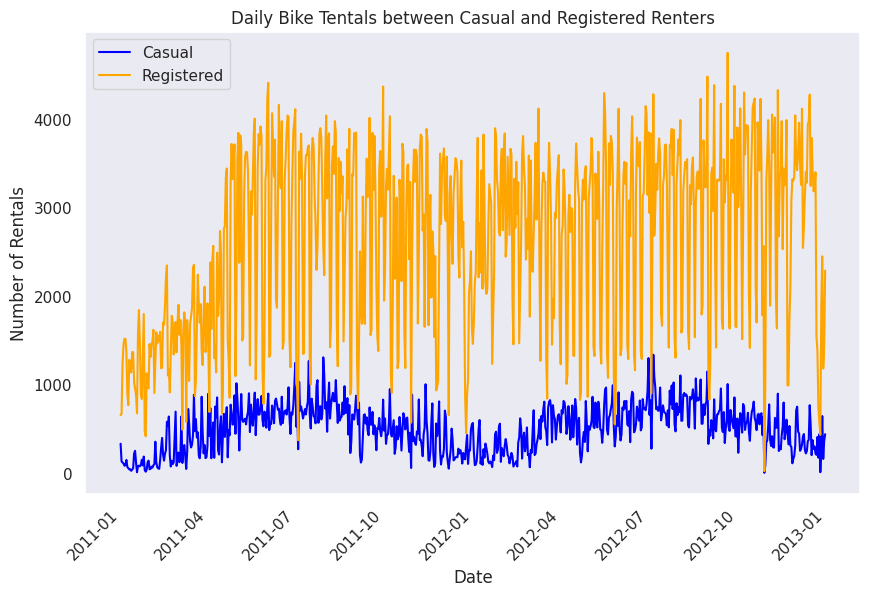

In [129]:
daily_rent = df__hour_no_outliers.groupby('dteday')[['casual', 'registered']].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=daily_rent, x='dteday', y='casual', label='Casual', color='blue')
sns.lineplot(data=daily_rent, x='dteday', y='registered', label='Registered', color='orange')
plt.title('Daily Bike Tentals between Casual and Registered Renters')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.legend()
plt.show()

**Insight:**

* Registered renters have a much higher number of rentals than casual renters. The trend of registered renters shows a fairly consistent pattern with recurring high fluctuations, especially in peak seasons.
* Casual renters have a much lower rental amount, but have seen a slight increase gradually over the same time period, especially in certain months.
* Higher fluctuations are seen in the data of registered renters compared to casual renters. This may indicate a seasonal pattern or peak days in bike rentals by registered renters.



### Pertanyaan 2: Apakah ada perbedaan penggunaan sepeda antara hari kerja dan akhir pekan, serta pada hari apa penggunaan tertinggi?

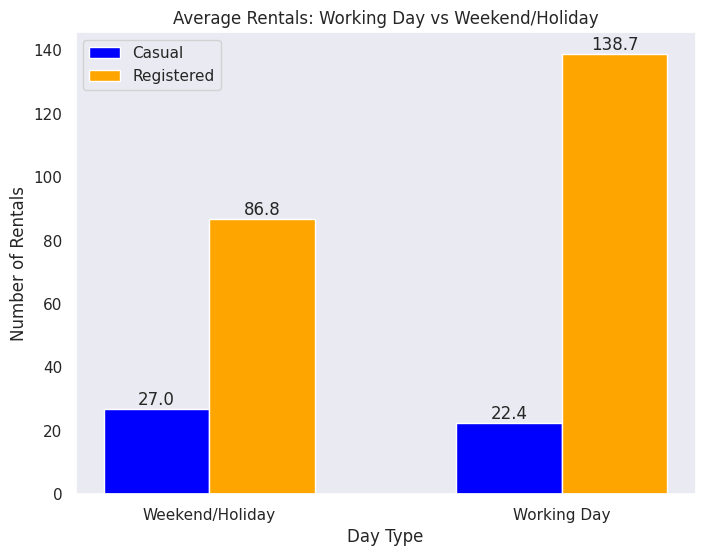

In [130]:
# Grouping data by working day
workingday_data = df__hour_no_outliers.groupby('workingday')[['casual', 'registered']].mean().reset_index()
workingday_data['day_type'] = workingday_data['workingday'].map({0: 'Weekend/Holiday', 1: 'Working Day'})

# Positions for bars
x = np.arange(len(workingday_data))  # Bars position
width = 0.30  # Width of each bar

# Creating the plot
plt.figure(figsize=(8, 6))

# Plotting casual data
bars1 = plt.bar(x - width / 2, workingday_data['casual'], width, color='blue', label='Casual')

# Plotting registered data
bars2 = plt.bar(x + width / 2, workingday_data['registered'], width, color='orange', label='Registered')

# Adding title and labels
plt.title('Average Rentals: Working Day vs Weekend/Holiday')
plt.ylabel('Number of Rentals')
plt.xlabel('Day Type')

plt.xticks(x, workingday_data['day_type'])
plt.legend()

# Adding bar labels
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height,
             f'{height:.1f}', ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height,
             f'{height:.1f}', ha='center', va='bottom')

# Show the plot
plt.show()

**Insight:**
- Registered Renters far outnumber Casual Renters, both on weekdays and weekends/holidays.
- Registered renters tend to use bicycles more often on weekdays, which suggests that they may use bicycles as a regular mode of transportation such as for commuting to work or school.
- Casual renters, on the other hand, tend to rent more often on weekends or holidays, which may indicate that they use bicycles more for recreation or leisure activities.

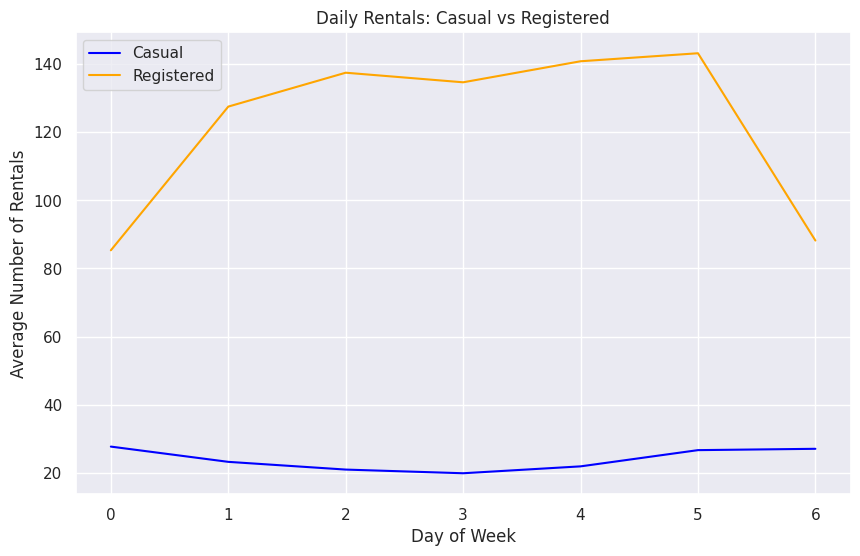

In [131]:
daily_data = df__hour_no_outliers.groupby('weekday')[['casual', 'registered']].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=daily_data, x='weekday', y='casual', label='Casual', color='blue')
sns.lineplot(data=daily_data, x='weekday', y='registered', label='Registered', color='orange')
plt.title('Daily Rentals: Casual vs Registered')
plt.xlabel('Day of Week')
plt.ylabel('Average Number of Rentals')
plt.legend()
plt.xticks(range(0, 7, 1))
plt.grid(True)
plt.show()

**Insight:**
- The number of casual renters rentals is relatively stable during weekdays (from 0 to 6 on the x-axis). The average number of rentals ranges from 20 to 30 bicycles.
- There is no significant fluctuation in the rental behavior of casual renters. This suggests that casual renters may use bicycles consistently without being affected by weekdays or holidays.
- Registered renters rentals show a clear trend during the week, with a significant increase at the beginning of the week (day 0) which is most likely Monday.
- Rentals peak mid to late week (around day 4 or 5), and drop sharply on the last day (day 6), which is most likely Sunday.
- This suggests that registered renters tend to be more active on bicycles during weekdays, especially in the middle to end of the week. The drop on the last day suggests that registered renters may be less likely to use bicycles on holidays or weekends.

### Pertanyaan 3: Jam berapakah penggunaan sepeda tertinggi dalam sehari?

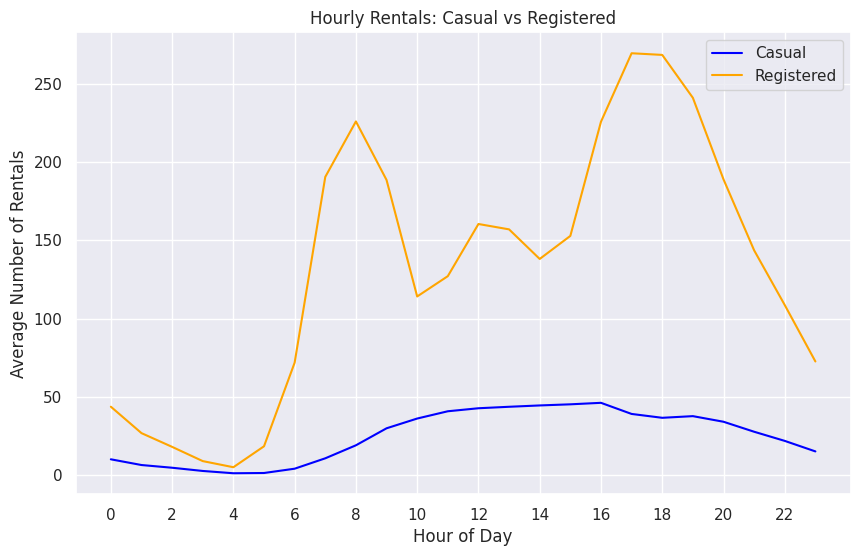

In [132]:
hourly_data = df__hour_no_outliers.groupby('hr')[['casual', 'registered']].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=hourly_data, x='hr', y='casual', label='Casual', color='blue')
sns.lineplot(data=hourly_data, x='hr', y='registered', label='Registered', color='orange')
plt.title('Hourly Rentals: Casual vs Registered')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Rentals')
plt.legend()
plt.xticks(range(0, 24, 2))
plt.grid(True)
plt.show()

**Insight:**
- Casual renters have a relatively stable rental pattern throughout the day. There are no significant spikes in the number of rentals where the number of rentals slowly increases starting from early morning (8am), peaks between 11am and 4pm, then slowly decreases after 6pm.
- Registered renters show a much clearer pattern with two peaks of activity. The first peak occurs around 8am, likely related to commuting to work. After the morning peak, the number of rentals declines, then rises again in the afternoon with a second peak around 17-18, likely related to the commute home from work. After 18pm, registered user bike rentals drop off dramatically until the end of the evening.

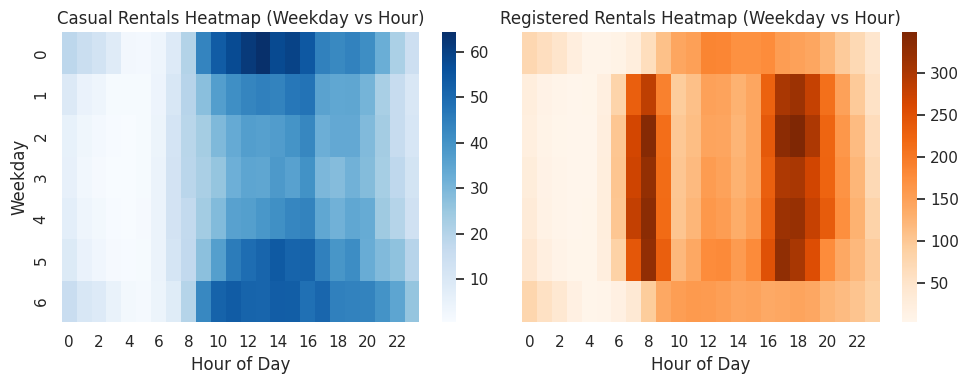

In [133]:
# Preparing data for heatmap
heatmap_data = df__hour_no_outliers.groupby(['weekday', 'hr'])[['casual', 'registered']].mean().unstack()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Heatmap for casual
sns.heatmap(heatmap_data['casual'], cmap='Blues', ax=axes[0], annot=False, cbar=True)
axes[0].set_title('Casual Rentals Heatmap (Weekday vs Hour)')
axes[0].set_ylabel('Weekday')
axes[0].set_xlabel('Hour of Day')

# Heatmap for registered
sns.heatmap(heatmap_data['registered'], cmap='Oranges', ax=axes[1], annot=False, cbar=True)
axes[1].set_title('Registered Rentals Heatmap (Weekday vs Hour)')
axes[1].set_ylabel('')  # Remove y-label for the second plot for cleaner look
axes[1].set_xlabel('Hour of Day')

# Show plots
plt.tight_layout()
plt.show()

**Insight:**
1. Casual Renter Heatmap (Left):
- Casual renters rental activity is higher between 10am and 6pm on all days of the week.
- This pattern is relatively consistent on both weekdays and weekends, with a slight increase on weekends (0 and 6) during the day.
- This suggests that casual renters are more likely to rent bicycles during the afternoon to evening, most likely for recreation or more leisurely activities.

2. Registered Renter Rentals Heatmap (Right):
- Registered renters rental activity shows a very distinct pattern, with two clear spikes: one in the morning between 7:00am and 9:00am, and another in the afternoon between 5:00pm and 7:00pm, especially on weekdays (1-5).
- On weekends (days 0 and 6), this pattern is hardly noticeable, with a lower number of rentals throughout the day.
- This confirms that registered renters tend to use bicycles as part of their daily commuting routine, especially to get to and from work on weekdays.

## Analisis Lanjutan: Time Series Decomposition

Time Series Decomposition to analyze bicycle rental usage trends in more depth.

Time Series Decomposition steps:
- Trend: The trend component shows the long-term direction of the data.
- Seasonality: The seasonal component captures patterns that repeat within a certain period (e.g., monthly or weekly patterns).
- Residuals: This component is the remainder of the data after the trend and seasonality are taken out.

Analyze the cnt (total rentals) column as a time series variable, focusing on trend decomposition, seasonality, and residuals.

<ipython-input-138-177196f179e4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df__hour_no_outliers['dteday'] = pd.to_datetime(df__hour_no_outliers['dteday'])


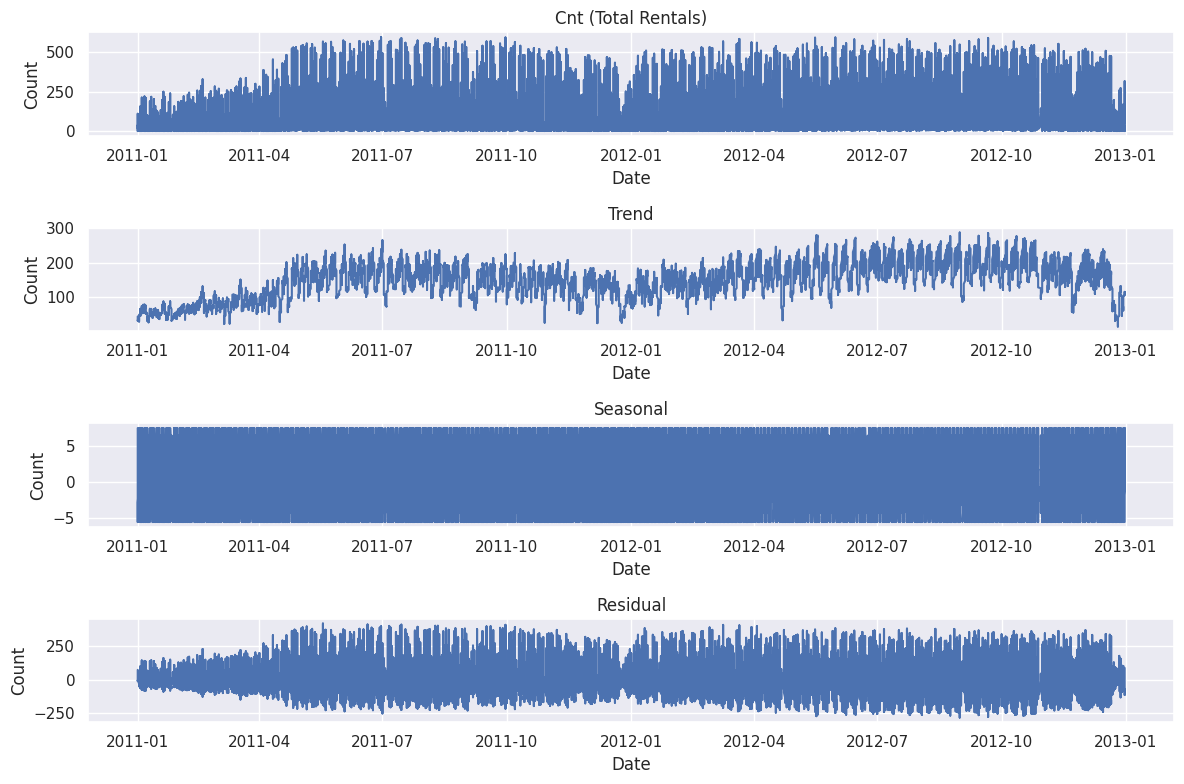

In [138]:
df__hour_no_outliers['dteday'] = pd.to_datetime(df__hour_no_outliers['dteday'])
df__hour_no_outliers.set_index('dteday', inplace=True)

tsd_data = df__hour_no_outliers['cnt']

# Perform time series decomposition (additive)
decomposition = seasonal_decompose(tsd_data, model='additive', period=30) # Period 30 because we assume there is a seasonal pattern per month

# Display the components of the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))

ax1.plot(decomposition.observed, label='Observed', color='b')
ax1.set_title('Cnt (Total Rentals)')
ax1.grid(True)

ax2.plot(decomposition.trend, label='Trend', color='b')
ax2.set_title('Trend')
ax2.grid(True)

ax3.plot(decomposition.seasonal, label='Seasonal', color='b')
ax3.set_title('Seasonal')
ax3.grid(True)

ax4.plot(decomposition.resid, label='Residual', color='b')
ax4.set_title('Residual')
ax4.grid(True)

# Menambahkan label pada sumbu X dan Y
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel('Date')
    ax.set_ylabel('Count')

# Menampilkan grafik
plt.tight_layout()
plt.show()


**Insight:**
1. Trend
- The trend shows a pattern of increasing bicycle usage over time.
- There was an increase in the number of bicycle rentals from early 2011 to mid-2012, followed by fluctuations. Despite the ups and downs, the general trend shows an increase during the analysis period.
- This could indicate that the popularity of bike sharing increased during the period, perhaps due to factors such as environmental awareness or convenience.
2. Seasonal
- The Seasonal component looks flat, which may indicate that the seasonal period used in the decomposition is not appropriate or the data does not have a significant seasonal pattern.
3. Residual
- The residuals are quite large and seem to contain a lot of variation, indicating that there are external variables or outliers affecting the number of bicycle rentals.

## Conclusion

**Q1: What is the pattern of rentals coming from casual renters compared to registered renters?**
- Registered renters: The previous data visualization shows that registered users have a more regular and stable bicycle rental pattern than general users. They tend to use bicycles consistently on weekdays, especially during peak hours (morning and evening), which may be related to their use of bicycles to get to and from work.
- Casual renters: Casual renters, on the other hand, show an increase in bicycle use on weekends or on holidays. These renters tend to use bicycles for recreational or personal use, hence the peak rentals occur on holidays or weekends.

**Conclusion:** Registered renters use bicycles more regularly on weekdays with peaks during peak hours, while casual renters are more likely to use bicycles on weekends and holidays.

**Q2: Is there a difference in bicycle usage between weekdays and weekends? Which days are the highest usage?**
- From the previous analysis and based on the time series decomposition pattern, it appears that bicycle usage is higher on weekdays compared to weekends for registered renters. This is consistent with the finding that bicycles are used by them for daily transportation, especially during working hours.
- For  casual renters, rental peaks tend to be higher on weekends, indicating a shift in usage from transportation to recreational purposes.
- Highest days of use: In general, weekdays (especially Monday to Friday) show the highest bicycle usage for registered renters. For casual renters, the highest usage may occur on Saturday or Sunday, when they have more free time.

**Conclusion:** Bicycle use by registered renters is more on weekdays, with peaks during these days, while casual renters tend to increase their bicycle use on weekends.

**Q3: What are the highest hours of bicycle use in a day?**
- Analysis of hourly patterns shows that the highest bicycle use occurs during the morning (around 8am) and afternoon (around 5pm) peak hours for registered renters. This reflects bicycle use for commuting to and from work, which is common in large cities.
- Casual renters tend to use bicycles more during the day, especially on weekends, when they may have more time for recreation.

**Conclusions:** The highest bicycle use on weekdays occurs during the morning and evening rush hours (8am and 5pm), while on weekends, use increases during the day.

**Time Series Decomposition Conclusion**

From the time series decomposition visualization, the trend component shows a gradual increase in bicycle usage, likely due to an increase in the number of registered renters over time.

The seasonal component shows consistent seasonal fluctuations from month to month, although in the resulting seasonal image, the pattern is not clearly visible. In general, seasonality or weather can also be a factor affecting bicycle usage patterns, but from this visualization, it does not appear to be significant.

The residual component shows random variation that has not been explained by the trend and seasonal components. This may indicate the presence of external factors not captured by the model, such as events or social conditions that affect bicycle usage.

Conclusion: The time series decomposition shows an increasing trend in bicycle use, but the seasonal pattern is difficult to clearly identify. External factors not explained by the model also affect the residuals.
